In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
from scipy.stats import skewnorm
import scipy as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def dataimporter(filename,header=77,undregräns_b=2,övregränds_b=2.7):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    data = nummerdata
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    return nummerdata


def dataimporterclean(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata

def bakgrund(x,c1,c2):
    return c1*x+c2

def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration_new(data,under=2,over=2.8,marginal=0.1):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))[0][0]
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))[0][0]
        x=i[intunder:intover,0]
        y = i[intunder:intover,1]
        
        mitten = x[np.argmax(y)]

        u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
        ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
        x=x[u:ö]
        y = y[u:ö]

        poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
        
        top1 =  np.sum(norm(x,*poptnorm))
        array = np.append(array,top1)
    return array


def data_integration(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def skew_normal(x, a, loc, scale,amp):
    return amp*skewnorm.cdf(x, a, loc=loc, scale=scale)

def skew_normal_pdf(x, a, loc, scale,amp):
    return amp*skewnorm.pdf(x, a, loc=loc, scale=scale)
def norm(x,a,mean,sigma):
    return a*stats.norm.pdf(x,mean,sigma)

def invnorm(x,a,mean,sigma):
    return a*stats.invgauss.pdf(x,mean,sigma)

In [4]:
# Old way of importing data
N15_10keV_60_1 = dataimporter("Measurements 090724/N15_10k_60_1.txt")
N15_10keV_60_2 = dataimporter("Measurements 090724/N15_10k_60_2.txt")
N15_10keV_60_3 = dataimporter("Measurements 090724/N15_10k_60_3.txt")
N15_10keV_60_4 = dataimporter("Measurements 090724/N15_10k_60_4.txt")
N15_10keV_60_5 = dataimporter("Measurements 090724/N15_10k_60_5.txt")

N8_10keV_60_1 = dataimporter("Measurements 090724/N8_10k_60_1.txt")
N8_10keV_60_2 = dataimporter("Measurements 090724/N8_10k_60_2.txt")
N8_10keV_60_3 = dataimporter("Measurements 090724/N8_10k_60_3.txt")

E7_10keV_60_1 = dataimporter("Measurements 090724/E7_10k_60_1.txt")
E7_10keV_60_2 = dataimporter("Measurements 090724/E7_10k_60_2.txt")
E7_10keV_60_3 = dataimporter("Measurements 090724/E7_10k_60_3.txt")

D9_10keV_60_1 = dataimporter("Measurements 090724/D9_10k_60_1.txt")
D9_10keV_60_2 = dataimporter("Measurements 090724/D9_10k_60_2.txt")
D9_10keV_60_3 = dataimporter("Measurements 090724/D9_10k_60_3.txt")

C10_10keV_60_1 = dataimporter("Measurements 090724/C10_10k_60_1.txt")
C10_10keV_60_2 = dataimporter("Measurements 090724/C10_10k_60_2.txt")
C10_10keV_60_3 = dataimporter("Measurements 090724/C10_10k_60_3.txt")


# old data importing
A10_15k_110724_1 = dataimporter("Measurements 110724/A10_15k_110724_1.txt",header=65)
A10_15k_110724_2 = dataimporter("Measurements 110724/A10_15k_110724_2.txt",header=65)
A10_15k_110724_3 = dataimporter("Measurements 110724/A10_15k_110724_3.txt",header=65)

B15_10k_100724_1 = dataimporter("Measurements 100724/B15_10k_100724_1.txt",header=65)
B15_10k_100724_2 = dataimporter("Measurements 100724/B15_10k_100724_2.txt",header=65)
B15_10k_100724_3 = dataimporter("Measurements 100724/B15_10k_100724_3.txt",header=65)

B15_10k_100724_A2_1 = dataimporter("Measurements 100724/B15_10k_100724_A2_1.txt",header=65)
B15_10k_100724_A2_2 = dataimporter("Measurements 100724/B15_10k_100724_A2_2.txt",header=65)
B15_10k_100724_A2_3 = dataimporter("Measurements 100724/B15_10k_100724_A2_3.txt",header=65)

B15_15k_100724_1 = dataimporter("Measurements 100724/B15_15k_100724_1.txt",header=65)
B15_15k_100724_2 = dataimporter("Measurements 100724/B15_15k_100724_2.txt",header=65)
B15_15k_100724_3 = dataimporter("Measurements 100724/B15_15k_100724_3.txt",header=65)

C10_10k_100724_1 = dataimporter("Measurements 100724/C10_10k_100724_1.txt",header=65)
C10_10k_100724_2 = dataimporter("Measurements 100724/C10_10k_100724_2.txt",header=65)
C10_10k_100724_3 = dataimporter("Measurements 100724/C10_10k_100724_3.txt",header=65)

C10_15k_100724_1 = dataimporter("Measurements 100724/C10_15k_100724_1.txt",header=65)
C10_15k_100724_2 = dataimporter("Measurements 100724/C10_15k_100724_2.txt",header=65)
C10_15k_100724_3 = dataimporter("Measurements 100724/C10_15k_100724_3.txt",header=65)

C10_10k_100724_A2_1 = dataimporter("Measurements 100724/C10_10k_100724_A2_1.txt",header=65)
C10_10k_100724_A2_2 = dataimporter("Measurements 100724/C10_10k_100724_A2_2.txt",header=65)
C10_10k_100724_A2_3 = dataimporter("Measurements 100724/C10_10k_100724_A2_3.txt",header=65)

C10_15k_100724_A2_1 = dataimporter("Measurements 100724/C10_15k_100724_A2_1.txt",header=65)
C10_15k_100724_A2_2 = dataimporter("Measurements 100724/C10_15k_100724_A2_2.txt",header=65)
C10_15k_100724_A2_3 = dataimporter("Measurements 100724/C10_15k_100724_A2_3.txt",header=65)

D9_10k_100724_1 = dataimporter("Measurements 100724/D9_10k_100724_1.txt",header=65)
D9_10k_100724_2 = dataimporter("Measurements 100724/D9_10k_100724_2.txt",header=65)
D9_10k_100724_3 = dataimporter("Measurements 100724/D9_10k_100724_3.txt",header=65)

D9_15k_100724_1 = dataimporter("Measurements 100724/D9_15k_100724_1.txt",header=65)
D9_15k_100724_2 = dataimporter("Measurements 100724/D9_15k_100724_2.txt",header=65)
D9_15k_100724_3 = dataimporter("Measurements 100724/D9_15k_100724_3.txt",header=65)

H12_10k_100724_1 = dataimporter("Measurements 100724/H12_10k_100724_1.txt",header=65)

H12_15k_100724_1 = dataimporter("Measurements 100724/H12_15k_100724_1.txt",header=65)

H9_15k_100724_1 = dataimporter("Measurements 100724/H9_15k_100724_1.txt",header=65)
H9_10k_100724_1 = dataimporter("Measurements 100724/H9_10k_100724_1.txt",header=65)

N8_10k_100724_1 = dataimporter("Measurements 100724/N8_10k_100724_1.txt",header=65)
N8_10k_100724_2 = dataimporter("Measurements 100724/N8_10k_100724_2.txt",header=65)
N8_10k_100724_3 = dataimporter("Measurements 100724/N8_10k_100724_3.txt",header=65)

N15_10k_100724_1 = dataimporter("Measurements 100724/N15_10k_100724_1.txt",header=65)
N15_10k_100724_2 = dataimporter("Measurements 100724/N15_10k_100724_2.txt",header=65)
N15_10k_100724_3 = dataimporter("Measurements 100724/N15_10k_100724_3.txt",header=65)

N15_15k_100724_1 = dataimporter("Measurements 100724/N15_15k_100724_1.txt",header=65)
N15_15k_100724_2 = dataimporter("Measurements 100724/N15_15k_100724_2.txt",header=65)
N15_15k_100724_3 = dataimporter("Measurements 100724/N15_15k_100724_3.txt",header=65)

C15_10k_2_100724_1 = dataimporter("Measurements 100724/C15_10k_2_100724_1.txt",header=65)
C15_15k_2_100724_1 = dataimporter("Measurements 100724/C15_15k_2_100724_1.txt",header=65)

C15_10k_100724 = dataimporter("Measurements 100724/C15_10k_100724.txt",header=65)
C15_15k_1_100724_1 = dataimporter("Measurements 100724/C15_15k_1_100724_1.txt",header=65)

F14_10k_100724 = dataimporter("Measurements 100724/F14_10k_100724_1.txt",header=65)


In [87]:
# Old way of importing data
N15_10keV_60_1 = dataimporter("Measurements 090724/N15_10k_60_1.txt")
N15_10keV_60_2 = dataimporter("Measurements 090724/N15_10k_60_2.txt")
N15_10keV_60_3 = dataimporter("Measurements 090724/N15_10k_60_3.txt")
N15_10keV_60_4 = dataimporter("Measurements 090724/N15_10k_60_4.txt")
N15_10keV_60_5 = dataimporter("Measurements 090724/N15_10k_60_5.txt")

N8_10keV_60_1 = dataimporter("Measurements 090724/N8_10k_60_1.txt")
N8_10keV_60_2 = dataimporter("Measurements 090724/N8_10k_60_2.txt")
N8_10keV_60_3 = dataimporter("Measurements 090724/N8_10k_60_3.txt")

E7_10keV_60_1 = dataimporter("Measurements 090724/E7_10k_60_1.txt")
E7_10keV_60_2 = dataimporter("Measurements 090724/E7_10k_60_2.txt")
E7_10keV_60_3 = dataimporter("Measurements 090724/E7_10k_60_3.txt")

D9_10keV_60_1 = dataimporter("Measurements 090724/D9_10k_60_1.txt")
D9_10keV_60_2 = dataimporter("Measurements 090724/D9_10k_60_2.txt")
D9_10keV_60_3 = dataimporter("Measurements 090724/D9_10k_60_3.txt")

C10_10keV_60_1 = dataimporter("Measurements 090724/C10_10k_60_1.txt")
C10_10keV_60_2 = dataimporter("Measurements 090724/C10_10k_60_2.txt")
C10_10keV_60_3 = dataimporter("Measurements 090724/C10_10k_60_3.txt")

N15_10K_0908 = np.array([N15_10keV_60_1,N15_10keV_60_2,N15_10keV_60_3,N15_10keV_60_3,N15_10keV_60_5])
N8_10keV_0908 = np.array([N8_10keV_60_1,N8_10keV_60_2,N8_10keV_60_3])
E7_10keV_0908 = np.array([E7_10keV_60_1,E7_10keV_60_2,E7_10keV_60_3])
D9_10keV_0908 = np.array([D9_10keV_60_1,D9_10keV_60_2,D9_10keV_60_3])
C10_10keV_0908 = np.array([C10_10keV_60_1,C10_10keV_60_2,C10_10keV_60_3])

N15_10K_0908_t = np.repeat(120,len(N15_10K_0908))
N8_10keV_0908_t = np.repeat(15,len(N8_10keV_0908))
E7_10keV_0908_t = np.repeat(1,len(E7_10keV_0908))
D9_10keV_0908_t = np.repeat(45,len(D9_10keV_0908))
C10_10keV_0908_t = np.repeat(45,len(C10_10keV_0908))

spec0908 = np.concatenate((data_integration(N15_10K_0908),data_integration(N8_10keV_0908),data_integration(D9_10keV_0908),data_integration(C10_10keV_0908)))
thick0908 = np.concatenate((N15_10K_0908_t,N8_10keV_0908_t,D9_10keV_0908_t,C10_10keV_0908_t))
specdata_0908 = np.array([spec0908,thick0908])
specdata_0908 = specdata_0908.T

# old data importing
A10_15k_110724_1 = dataimporter("Measurements 110724/A10_15k_110724_1.txt",header=65)
A10_15k_110724_2 = dataimporter("Measurements 110724/A10_15k_110724_2.txt",header=65)
A10_15k_110724_3 = dataimporter("Measurements 110724/A10_15k_110724_3.txt",header=65)

B15_10k_100724_1 = dataimporter("Measurements 100724/B15_10k_100724_1.txt",header=65)
B15_10k_100724_2 = dataimporter("Measurements 100724/B15_10k_100724_2.txt",header=65)
B15_10k_100724_3 = dataimporter("Measurements 100724/B15_10k_100724_3.txt",header=65)

B15_10k_100724_A2_1 = dataimporter("Measurements 100724/B15_10k_100724_A2_1.txt",header=65)
B15_10k_100724_A2_2 = dataimporter("Measurements 100724/B15_10k_100724_A2_2.txt",header=65)
B15_10k_100724_A2_3 = dataimporter("Measurements 100724/B15_10k_100724_A2_3.txt",header=65)

B15_15k_100724_1 = dataimporter("Measurements 100724/B15_15k_100724_1.txt",header=65)
B15_15k_100724_2 = dataimporter("Measurements 100724/B15_15k_100724_2.txt",header=65)
B15_15k_100724_3 = dataimporter("Measurements 100724/B15_15k_100724_3.txt",header=65)

C10_10k_100724_1 = dataimporter("Measurements 100724/C10_10k_100724_1.txt",header=65)
C10_10k_100724_2 = dataimporter("Measurements 100724/C10_10k_100724_2.txt",header=65)
C10_10k_100724_3 = dataimporter("Measurements 100724/C10_10k_100724_3.txt",header=65)

C10_15k_100724_1 = dataimporter("Measurements 100724/C10_15k_100724_1.txt",header=65)
C10_15k_100724_2 = dataimporter("Measurements 100724/C10_15k_100724_2.txt",header=65)
C10_15k_100724_3 = dataimporter("Measurements 100724/C10_15k_100724_3.txt",header=65)

C10_10k_100724_A2_1 = dataimporter("Measurements 100724/C10_10k_100724_A2_1.txt",header=65)
C10_10k_100724_A2_2 = dataimporter("Measurements 100724/C10_10k_100724_A2_2.txt",header=65)
C10_10k_100724_A2_3 = dataimporter("Measurements 100724/C10_10k_100724_A2_3.txt",header=65)

C10_15k_100724_A2_1 = dataimporter("Measurements 100724/C10_15k_100724_A2_1.txt",header=65)
C10_15k_100724_A2_2 = dataimporter("Measurements 100724/C10_15k_100724_A2_2.txt",header=65)
C10_15k_100724_A2_3 = dataimporter("Measurements 100724/C10_15k_100724_A2_3.txt",header=65)

D9_10k_100724_1 = dataimporter("Measurements 100724/D9_10k_100724_1.txt",header=65)
D9_10k_100724_2 = dataimporter("Measurements 100724/D9_10k_100724_2.txt",header=65)
D9_10k_100724_3 = dataimporter("Measurements 100724/D9_10k_100724_3.txt",header=65)

D9_15k_100724_1 = dataimporter("Measurements 100724/D9_15k_100724_1.txt",header=65)
D9_15k_100724_2 = dataimporter("Measurements 100724/D9_15k_100724_2.txt",header=65)
D9_15k_100724_3 = dataimporter("Measurements 100724/D9_15k_100724_3.txt",header=65)

H12_10k_100724_1 = dataimporter("Measurements 100724/H12_10k_100724_1.txt",header=65)

H12_15k_100724_1 = dataimporter("Measurements 100724/H12_15k_100724_1.txt",header=65)

H9_15k_100724_1 = dataimporter("Measurements 100724/H9_15k_100724_1.txt",header=65)
H9_10k_100724_1 = dataimporter("Measurements 100724/H9_10k_100724_1.txt",header=65)

N8_10k_100724_1 = dataimporter("Measurements 100724/N8_10k_100724_1.txt",header=65)
N8_10k_100724_2 = dataimporter("Measurements 100724/N8_10k_100724_2.txt",header=65)
N8_10k_100724_3 = dataimporter("Measurements 100724/N8_10k_100724_3.txt",header=65)

N15_10k_100724_1 = dataimporter("Measurements 100724/N15_10k_100724_1.txt",header=65)
N15_10k_100724_2 = dataimporter("Measurements 100724/N15_10k_100724_2.txt",header=65)
N15_10k_100724_3 = dataimporter("Measurements 100724/N15_10k_100724_3.txt",header=65)

N15_15k_100724_1 = dataimporter("Measurements 100724/N15_15k_100724_1.txt",header=65)
N15_15k_100724_2 = dataimporter("Measurements 100724/N15_15k_100724_2.txt",header=65)
N15_15k_100724_3 = dataimporter("Measurements 100724/N15_15k_100724_3.txt",header=65)

C15_10k_2_100724_1 = dataimporter("Measurements 100724/C15_10k_2_100724_1.txt",header=65)
C15_15k_2_100724_1 = dataimporter("Measurements 100724/C15_15k_2_100724_1.txt",header=65)

C15_10k_100724 = dataimporter("Measurements 100724/C15_10k_100724.txt",header=65)
C15_15k_1_100724_1 = dataimporter("Measurements 100724/C15_15k_1_100724_1.txt",header=65)

F14_10k_100724 = dataimporter("Measurements 100724/F14_10k_100724_1.txt",header=65)

# Creating pandas data frames
spectraldata15 = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])
spectraldata10 = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])

spectraldata15points = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])
spectraldata10points = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])

# newer data importing
H12_10k = data_integration([H12_10k_100724_1])
H12_15k = data_integration([H12_10k_100724_1])
spectraldata10.loc["H12 Area 1"] = [H12_10k[0],7.019819680052666e-08,7.352929558938202e-12,(np.max(H12_10k)-np.min(H12_10k))/2]
spectraldata15.loc["H12 Area 1"] = [H12_15k[0],7.019819680052666e-08,7.352929558938202e-12,(np.max(H12_15k)-np.min(H12_15k))/2]


A10_15keV_110724 = data_integration([A10_15k_110724_2,A10_15k_110724_1,A10_15k_110724_3])

spectraldata15points.loc["A10 Area 1"] = [np.mean(A10_15keV_110724),6.77603162563611e-07,2e-10,(np.max(A10_15keV_110724)-np.min(A10_15keV_110724))/2]

F14_10k_100724 = data_integration([F14_10k_100724])

C15_10k_100724_A1 = data_integration([C15_10k_100724])
C15A1_thickness_10 = np.repeat(220,len(C15_10k_100724_A1))
# 2.507745896825397e-07
# spectraldata10.loc["C15 Area 1"] = [C15_10k_100724_A1[0],2.507745896825397e-07,0,(np.max(C15_10k_100724_A1)-np.min(C15_10k_100724_A1))/2]

C15_10k_100724_A2 = data_integration([C15_10k_2_100724_1])
spectraldata10.loc["C15 Area 2"] = [C15_10k_100724_A2[0],1.5232782994124567e-07,0,(np.max(C15_10k_100724_A2)-np.min(C15_10k_100724_A2))/2]

C15_15k_100724_A1 = data_integration([C15_15k_1_100724_1])
C15_15k_100724_A2 = data_integration([C15_15k_2_100724_1])


B15_10k_100724 = data_integration([B15_10k_100724_1,B15_10k_100724_2,B15_10k_100724_3])
B15_10k_100724_A2 = data_integration([B15_10k_100724_A2_1,B15_10k_100724_A2_2,B15_10k_100724_A2_3])
# spectraldata10.loc["B15 Area 1"] = [np.mean(B15_10k_100724),5.763391e-08,0,(np.max(B15_10k_100724)-np.min(B15_10k_100724))/2]
# spectraldata10.loc["B15 Area 2"] = [np.mean(B15_10k_100724_A2),4.727011458370342e-08,6.7952968476364225e-09,(np.max(C10_15k_100724)-np.min(C10_15k_100724))/2]


B15_15k_100724 = data_integration([B15_15k_100724_1,B15_15k_100724_2,B15_15k_100724_3])
B15A1_thick_15 = np.repeat(59.1,len(B15_15k_100724))

C10_10k_100724 = data_integration([C10_10k_100724_1,C10_10k_100724_2,C10_10k_100724_3])
C10_15k_100724 = data_integration([C10_15k_100724_1,C10_15k_100724_2,C10_15k_100724_3])
spectraldata10.loc["C10 Area 1"] = [np.mean(C10_10k_100724),5.472002590182196e-08,2.6796075100419003e-10,(np.max(C10_10k_100724)-np.min(C10_10k_100724))/2]
spectraldata15.loc["C10 Area 1"] = [np.mean(C10_15k_100724),5.472002590182196e-08,2.6796075100419003e-10,(np.max(C10_15k_100724)-np.min(C10_15k_100724))/2]

C10_10k_100724_A2 = data_integration([C10_10k_100724_A2_1,C10_10k_100724_A2_2,C10_10k_100724_A2_3])
C10_15k_100724_A2 = data_integration([C10_15k_100724_A2_1,C10_15k_100724_A2_2,C10_15k_100724_A2_3])
spectraldata10.loc["C10 Area 2"] = [np.mean(C10_10k_100724_A2),6.621983698283349e-08,1.3301237713190631e-11,(np.max(C10_10k_100724_A2)-np.min(C10_10k_100724_A2))/2]
spectraldata15.loc["C10 Area 2"] = [np.mean(C10_15k_100724_A2),6.621983698283349e-08,4.768952002078188e-11,(np.max(C10_15k_100724_A2)-np.min(C10_15k_100724_A2))/2]


H9_10k_100724 = data_integration([H9_10k_100724_1])
H9_15k_100724 = data_integration([H9_15k_100724_1])
# spectraldata10.loc["H9 Area 1"] = [np.mean(H9_10k_100724),2.3437525949463097e-07,6.465786941306329e-10,(np.max(H9_10k_100724)-np.min(H9_10k_100724))/2]
# spectraldata15.loc["H9 Area 1"] = [np.mean(H9_15k_100724),2.3437525949463097e-07,6.465786941306329e-10,(np.max(H9_15k_100724)-np.min(H9_15k_100724))/2]

D9_10k_100724 = data_integration([D9_10k_100724_1,D9_10k_100724_2,D9_10k_100724_3])
D9_15k_100724 = data_integration([D9_15k_100724_1,D9_15k_100724_2,D9_15k_100724_3])
spectraldata10.loc["D9 Area 1"] = [np.mean(D9_10k_100724),8.935509295988247e-09,1.3226966576479678e-11,(np.max(D9_10k_100724)-np.min(D9_10k_100724))/2]
spectraldata15.loc["D9 Area 1"] = [np.mean(D9_15k_100724),8.935509295988247e-09,1.3226966576479678e-11,(np.max(D9_15k_100724)-np.min(D9_15k_100724))/2]

N8_10k_100724 = data_integration([N8_10k_100724_1,N8_10k_100724_2,N8_10k_100724_3])
spectraldata10.loc["N8 Area 1"] = [np.mean(N8_10k_100724),1.4763913340391209e-08,1.3226966576479678e-11,(np.max(N8_10k_100724)-np.min(N8_10k_100724))/2]

N15_10k_100724 = data_integration([N15_10k_100724_1,N15_10k_100724_2,N15_10k_100724_3])
N15_15k_100724 = data_integration([N15_15k_100724_1,N15_15k_100724_2,N15_15k_100724_3])
spectraldata10.loc["N15 Area 1"] = [np.mean(N15_10k_100724),1.1991117601449273e-07,1.5516981225296182e-10,(np.max(N15_10k_100724)-np.min(N15_10k_100724))/2]
spectraldata15.loc["N15 Area 1"] = [np.mean(N15_15k_100724),1.1991117601449273e-07,1.5516981225296182e-10,(np.max(N15_15k_100724)-np.min(N15_15k_100724))/2]
# Latest way of data importation
H910k = readfile(["Spectras 300724/H9_10k_310724_1.txt","Spectras 300724/H9_10k_310724_2.txt","Spectras 300724/H9_10k_310724_3.txt","Spectras 300724/H9_10k_310724_4.txt","Spectras 300724/H9_10k_310724_5.txt","Measurements 100724/H9_10k_100724_1.txt"])
spectraldata10.loc["H9 Area 1"] = [np.mean(H910k),2.3437525949463097e-07,6.465786941306329e-10,(np.max(H910k)-np.min(H910k))/2]

H915k = readfile(["Spectras 300724/H9_15k_310724_1.txt","Spectras 300724/H9_15k_310724_2.txt","Spectras 300724/H9_15k_310724_3.txt","Spectras 300724/H9_15k_310724_4.txt","Spectras 300724/H9_15k_310724_5.txt","Measurements 100724/H9_15k_100724_1.txt"])
spectraldata15.loc["H9 Area 1"] = [np.mean(H915k),2.3437525949463097e-07,6.465786941306329e-10,(np.max(H915k)-np.min(H915k))/2]

C15A110k = readfile(["Spectras 300724/C15A1_10k_310724_1.txt","Spectras 300724/C15A1_10k_310724_2.txt","Spectras 300724/C15A1_10k_310724_1.txt"])
spectraldata10.loc["C15 Area 1"] = [np.mean(C15A110k),2.507745896825397e-07,0,(np.max(C15A110k)-np.min(C15A110k))/2]

C15A115k = readfile(["Spectras 300724/C15A1_15k_310724_1.txt","Spectras 300724/C15A1_15k_310724_2.txt","Spectras 300724/C15A1_15k_310724_1.txt"])
spectraldata15.loc["C15 Area 1"] = [np.mean(C15A115k),2.507745896825397e-07,0,(np.max(C15A115k)-np.min(C15A115k))/2]

#Kolla datapunkterna på den här
B15A110k = readfile(["Spectras 300724/B15_10k_310724_1.txt","Spectras 300724/B15_10k_310724_2.txt","Spectras 300724/B15_10k_310724_3.txt","Spectras 300724/B15_10k_310724_5.txt","Spectras 300724/B15_10k_310724_6_point.txt","Spectras 300724/B15_10k_310724_7.txt","Spectras 300724/B15_10k_310724_8.txt"])
spectraldata10.loc["B15 Area 1"] = [np.mean(B15A110k),5.763391e-08,2e-10,(np.max(B15A110k)-np.min(B15A110k))/2]

B15A115k = readfile(["Spectras 300724/B15_15k_310724_1.txt","Spectras 300724/B15_15k_310724_2.txt","Spectras 300724/B15_15k_310724_3.txt"])
spectraldata15.loc["B15 Area 1"] = [np.mean(B15A115k),5.763391e-08,2e-10,(np.max(B15A115k)-np.min(B15A115k))/2]

A1010k = readfile(["Spectras 300724/A10_10k_310724_1.txt","Spectras 300724/A10_10k_310724_2.txt","Spectras 300724/A10_10k_310724_3.txt"])
spectraldata10points.loc["A10 Area 1"] = [np.mean(A1010k),6.77603162563611e-07,2e-10,(np.max(A1010k)-np.min(A1010k))/2]
spectraldata10.loc["A10 Area 1"] = [np.mean(A1010k),6.77603162563611e-07,2e-10,(np.max(A1010k)-np.min(A1010k))/2]

zeropoint = readfile(["spectras 010824/Zero_2.txt","spectras 010824/Zero_3.txt"])
spectraldata10points.loc["zero"] = [np.mean(zeropoint),0,0,(np.max(zeropoint)-np.min(zeropoint))/2]
spectraldata10.loc["zero"] = [np.mean(zeropoint),0,0,(np.max(zeropoint)-np.min(zeropoint))/2]

#Chip 3
PATH = "Spectras 20250424/"

C7 = readfile([PATH+"20250425_10K_C7_1.txt",PATH+"20250425_10K_C7_2.txt",PATH+"20250425_10K_C7_3.txt"])
spectraldata10.loc["C7"] = [np.mean(C7),151.2e-9,0.3e-9,(np.max(C7)-np.min(C7))/2]

D2 = readfile([PATH+"20250425_10K_D2_1.txt",PATH+"20250425_10K_D2_2.txt",PATH+"20250425_10K_D2_3.txt"])
spectraldata10.loc["D2"] = [np.mean(D2),4.23e-9,0.46e-9,(np.max(D2)-np.min(D2))/2]

N10_A1 = readfile([PATH+"20250425_10K_N10_area1_1.txt",PATH+"20250425_10K_N10_area1_2.txt",PATH+"20250425_10K_N10_area1_3.txt"])
spectraldata10.loc["N10_A1"] = [np.mean(N10_A1),27.24e-9,0.38e-9,(np.max(N10_A1)-np.min(N10_A1))/2]

N10_A2 = readfile([PATH+"20250425_10K_N10_area2_1.txt",PATH+"20250425_10K_N10_area2_2.txt",PATH+"20250425_10K_N10_area2_3.txt"])
spectraldata10.loc["N10_A1"] = [np.mean(N10_A2),151.2e-9,0.38e-9,(np.max(N10_A2)-np.min(N10_A2))/2]

G10_A1 = readfile([PATH+"20250425_10K_G10_1.txt",PATH+"20250425_10K_G10_2.txt",PATH+"20250425_10K_G10_3.txt"])
spectraldata10.loc["G10_A1"] = [np.mean(G10_A1),4.85e-9,0.38e-9,(np.max(G10_A1)-np.min(G10_A1))/2]

G10_A2 = 0#readfile([PATH+"20250425_10K_G10_aera2.txt"])
spectraldata10.loc["G10_A1"] = [np.mean(G10_A2),6.7e-9,0.330e-9,(np.max(G10_A2)-np.min(G10_A2))/2]



spectraldata10.sort_values(by=['tcps'],inplace=True)
spectraldata15.sort_values(by=['tcps'],inplace=True)
spectraldata10points.sort_values(by=['tcps'],inplace=True)
spectraldata15points.sort_values(by=['tcps'],inplace=True)

spectraldata10.to_csv("Databases/spectraldata10.csv")


print(spectraldata10)
print(spectraldata10.loc["G10_A1"]["tcps"])
print(spectraldata10.loc["D9 Area 1"]["tcps"])


                    tcps     thickness  thicknesserror   tcpserror
G10_A1          0.000000  6.700000e-09    3.300000e-10    0.000000
zero           11.003959  0.000000e+00    0.000000e+00   21.058364
D2            368.025043  4.230000e-09    4.600000e-10   70.813924
D9 Area 1     374.315081  8.935509e-09    1.322697e-11   42.033063
N8 Area 1     966.378040  1.476391e-08    1.322697e-11   84.908740
C10 Area 1   3442.891922  5.472003e-08    2.679608e-10  113.444839
B15 Area 1   3654.286757  5.763391e-08    2.000000e-10   90.842919
C10 Area 2   4231.235324  6.621984e-08    1.330124e-11   55.282510
H12 Area 1   4611.299796  7.019820e-08    7.352930e-12    0.000000
N15 Area 1   8349.516020  1.199112e-07    1.551698e-10  153.739212
N10_A1       9860.383075  1.512000e-07    3.800000e-10   36.396168
C15 Area 2   9930.440673  1.523278e-07    0.000000e+00    0.000000
H9 Area 1   15793.868587  2.343753e-07    6.465787e-10  131.967832
C15 Area 1  16529.544532  2.507746e-07    0.000000e+00  225.26

In [11]:
spectraldata5keVhelios = pd.DataFrame(columns=["tcps","thickness"])

J1 = readfile(["Tokyo measurmetns/J1_bulk_pt1.psmsa"])

G10_2 = readfile(["Tokyo measurmetns/G10_2_pt1.psmsa"])
spectraldata5keVhelios.loc["G10_2"] = [G10_2[0]/J1[0],10]

G10_1 = readfile(["Tokyo measurmetns/G10_thinnest_pt1.psmsa"])
spectraldata5keVhelios.loc["G10_1"] = [G10_1[0]/J1[0],60]

zero = readfile(["Tokyo measurmetns/Background_pt1.psmsa"])
spectraldata5keVhelios.loc["zero"] = [zero[0]/J1[0],0]

C6 = readfile(["Tokyo measurmetns/C6_pt1.psmsa"])
spectraldata5keVhelios.loc["C6"] = [C6[0]/J1[0],20]

D2_1 = readfile(["Tokyo measurmetns/D2_bilayermabey_area2_pt1.psmsa"])
spectraldata5keVhelios.loc["D2_1"] = [D2_1[0]/J1[0],30]

D2_2 = readfile(["Tokyo measurmetns/D2_thinn_Area1_pt1.psmsa"])
# spectraldata5keVhelios.loc["D2_2"] = [D2_2[0]/J1[0],40]

F1 = readfile(["Tokyo measurmetns/F1_pt1.psmsa"])
spectraldata5keVhelios.loc["F1"] = [F1[0]/J1[0],40]

N10 = readfile(["Tokyo measurmetns/N10_thick_area1_pt1.psmsa"])
spectraldata5keVhelios.loc["N10"] = [N10[0]/J1[0],100]

N10_2 = readfile(["Tokyo measurmetns/N10_thick_area2_pt1.psmsa"])
spectraldata5keVhelios.loc["N10_2"] = [N10_2[0]/J1[0],100]


In [12]:
print(spectraldata5keVhelios)

           tcps  thickness
G10_2  0.041490       10.0
G10_1  0.032130       60.0
zero  -0.008003        0.0
C6     0.280145       20.0
D2_1   0.056007       30.0
F1     0.280212       40.0
N10    1.666462      100.0
N10_2  0.791806      100.0


In [7]:
x_before = spectraldata10["thickness"].to_numpy()*10**9
y_after = spectraldata10["tcps"].to_numpy()

In [91]:
simdata = np.loadtxt("Xray/mo_lg.csv")

In [88]:
spectraldata10 = spectraldata10.drop("C7")
spectraldata10 = spectraldata10.drop("G10_A1")

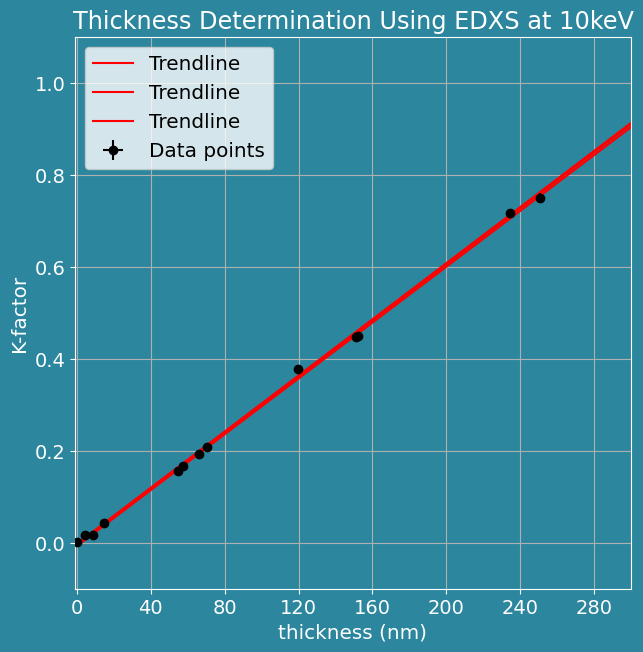

2.053446437048597
[0.01486872 1.55808072]


In [245]:


x = spectraldata10["thickness"].to_numpy()*10**9
y = spectraldata10["tcps"].to_numpy()

x_hög = spectraldata10["thickness"].to_numpy()*10**9+spectraldata10["thicknesserror"].to_numpy()*10**9
y_hög = spectraldata10["tcps"].to_numpy() + spectraldata10["tcpserror"].to_numpy()

x_låg = spectraldata10["thickness"].to_numpy()*10**9+spectraldata10["thicknesserror"].to_numpy()*10**9
y_låg = spectraldata10["tcps"].to_numpy() - spectraldata10["tcpserror"].to_numpy()

thi = np.linspace(0,700,1000)

con10 = np.polyfit(x[:-2],y[:-2],1)
con10_hög = np.polyfit(x_hög[:-2],y_hög[:-2],1)
con10_låg = np.polyfit(x_låg[:-2],y_låg[:-2],1)
conp10 = np.polyfit(y[:-2],x[:-2],1)
conp10_hög = np.polyfit(y_hög[:-2],x_hög[:-2],1)
conp10_låg = np.polyfit(y_låg[:-2],x_låg[:-2],1)

# print(np.concatenate((x[:8],x[9:])))
# print(x[8])
#Skew normal analasys
# poptry,pcov = sp.optimize.curve_fit(skew_normal,xdata=np.concatenate((x[:8],x[9:])),ydata=np.concatenate((y[:8],y[9:])),p0=[0.001,1,277.86757077762036,1])
popt,pcov = sp.optimize.curve_fit(skew_normal,xdata=x,ydata=y,p0=[0.001,1,277.86757077762036,1])
fig, ax = plt.subplots(1)
fig.set_size_inches(7.17,7.17)
# Plotting for 10keV model
ax.errorbar(x,y/(spectraldata10["tcps"].to_numpy()[-1]),yerr = spectraldata10["tcpserror"].to_numpy()/(spectraldata10["tcps"].to_numpy()[-1]),xerr= spectraldata10["thicknesserror"].to_numpy()*10**9,color="black",zorder = 4,fmt="o",label="Data points")
# ax.errorbar(spectraldata10points["thickness"].to_numpy()*10**9,spectraldata10points["tcps"].to_numpy(),yerr = spectraldata10points["tcpserror"].to_numpy(),xerr= spectraldata10points["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
ax.plot(thi,(con10[0]*thi+con10[1])/(spectraldata10["tcps"].to_numpy()[-1]),color = "red",zorder = 2,label="Trendline")
ax.plot(thi,(con10_hög[0]*thi+con10_hög[1])/(spectraldata10["tcps"].to_numpy()[-1]),color = "red",zorder = 2,label="Trendline")
ax.plot(thi,(con10_låg[0]*thi+con10_låg[1])/(spectraldata10["tcps"].to_numpy()[-1]),color = "red",zorder = 2,label="Trendline")
# ax.plot(thi,skew_normal(thi,*popt))
# ax.plot(thi,skew_normal(thi,*poptry))
# ax.scatter(x[8],y[8],zorder=20,color="yellow")

# ax.scatter(spectraldata5keVhelios["thickness"],spectraldata5keVhelios["tcps"],zorder=20)

# ax.plot(simdata[:,0],simdata[:,1])
ax.set_xlabel("thickness (nm)",fontsize="x-large",color="white")
ax.set_ylabel("K-factor",fontsize="x-large",color="white")
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.tick_params(axis='y', which='major', labelsize=14,color="white",labelcolor="w")
ax.tick_params(axis='x', which='major', labelsize=14,color="white",labelcolor="w")
ax.grid(zorder=1)
# ax[i].legend()
ax.set_ylim((-0.1,1.1))
ax.set_xlim((-1,300))
ax.set_title("Thickness Determination Using EDXS at 10keV",fontsize="xx-large",color="white")
# ax.set_xlim((0,10))
# ax.set_ylim((-0.05,0.2))
ax.legend(fontsize="x-large")
ax.set_facecolor(np.array([43,134,158])/255)
fig.patch.set_color(np.array([43,134,158])/255)
for spine in ax.spines.values():
        spine.set_edgecolor("w")
# plt.savefig('filename.png', format='png', dpi=600, transparent=True)

plt.show()
a = conp10_hög[0]*spectraldata10["tcps"].to_numpy()[2]+conp10_hög[1]
b = conp10_låg[0]*spectraldata10["tcps"].to_numpy()[2]+conp10_låg[1]
c = b-a
f = y[:-1]
# f = np.delete(f,9)
f = np.delete(f,8)
# f = np.delete(f,10)
e = x[:-1]
# e = np.delete(e,9)
e = np.delete(e,8)
# e = np.delete(e,10)
d = conp10[0]*f + conp10[1]
# print(conp10[0]*spectraldata10["tcps"].to_numpy()[2]+conp10[1], conp10[0]*spectraldata10["tcpserror"].to_numpy()[2]+c)
# print(a)
# print(b)
print(np.mean(np.abs((d-e))))
print(conp10)

In [16]:
def försök(filename,header=70,övregränds_b=5,undregräns_b=3,find_gauss_over=2,find_guass_under=2.7,marginal=0.1):
    #Import data
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    data = np.asarray(nummer[:-1,:], dtype="float")
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    print(bu,bö)
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    
    #Fitting of gaussian on peak

    intunder = np.where(data[:,0]==find_nearest(data[:,0],find_gauss_over))[0][0]
    intover = np.where(data[:,0]==find_nearest(data[:,0],find_guass_under))[0][0]

    x=data[intunder:intover,0]
    y = data[intunder:intover,1]

    mitten = x[np.argmax(data[intunder:intover,1])]

    u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
    ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
    x=x[u:ö]
    y = y[u:ö]

    poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
    
    return np.sum(norm(x,*poptnorm))
    

Here i will insvestigate the importing method and try to eliminate the background and get a good measurment

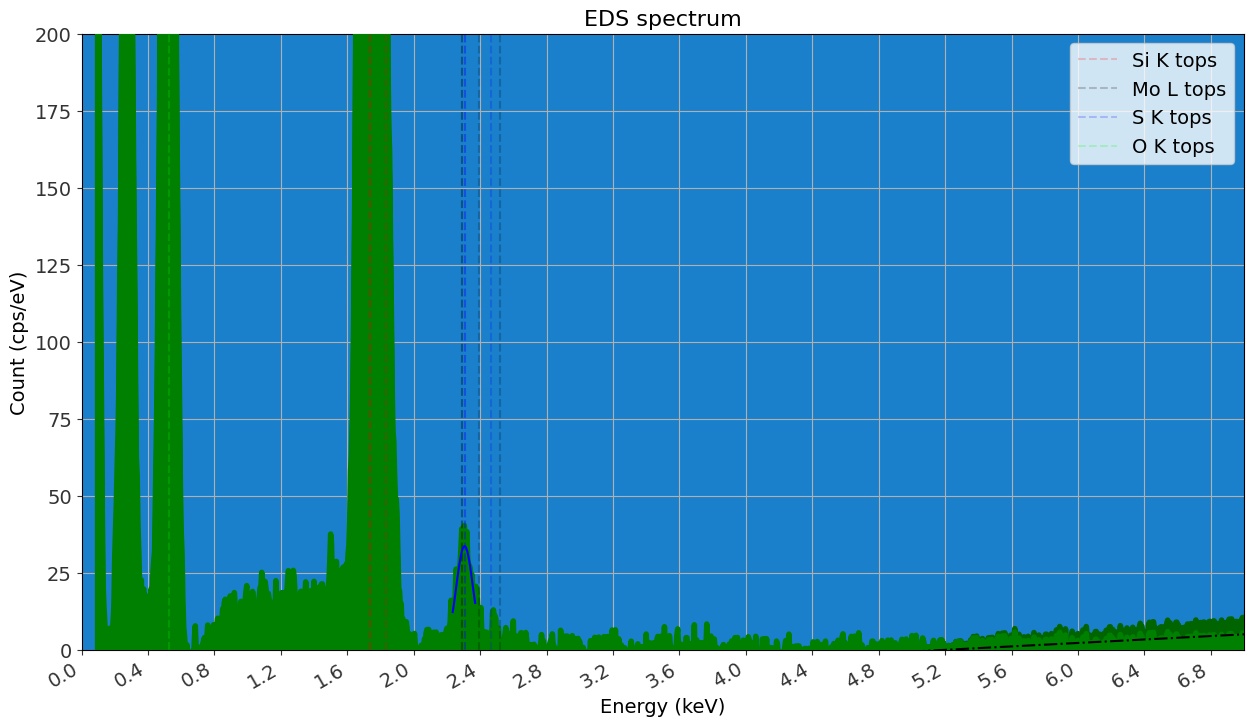

In [ ]:
# Defining constants

Molines = [2.29316, 2.28985, 2.39481, 2.5183]
Silines = [1.73998,1.73938, 1.83594]
Slines = [2.30784,2.30664,2.46404]
Olines =[0.5249] 
Nticks = 20
xmax = 7
xmin = 0
ymax = 200
marginal = 0.07

# Creating plot figure and tick formating function
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
fmt = lambda x, pos: '{}'.format(x).rstrip('0')

data = dataimporter("Measurements 100724/D9_10k_100724_3.txt")

#Fitting of the background
def bakgrund(x,c1,c2):
    return c1*x+c2
bu = np.where(data[:,0]==find_nearest(data[:,0],3))[0][0]
bö = np.where(data[:,0]==find_nearest(data[:,0],5))[0][0]

xb = data[bu:bö,0]
yb = data[bu:bö,1]

poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])

data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)

#Fitting of gaussian on peak

intunder = np.where(data[:,0]==find_nearest(data[:,0],2))[0][0]
intover = np.where(data[:,0]==find_nearest(data[:,0],2.7))[0][0]

x=data[intunder:intover,0]
y = data[intunder:intover,1]

mitten = x[np.argmax(data[intunder:intover,1])]

u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
x=x[u:ö]
y = y[u:ö]

poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])

plotter(ax,dataimporter("Measurements 100724/D9_10k_100724_3.txt"),6,"darkgreen",None)
plotter(ax,data,6,"green",None)
# plotter(ax,dataimporter("Measurements 100724/D9_10k_100724_3.txt"),6,"green",None)
# plotter(ax,dataimporter("Spectras 300724/C15A1_10k_310724_1.txt"),7,"red",None)
# plotter(ax,dataimporter("Spectras 300724/C15A1_10k_310724_3.txt"),7,"blue",None)
# plotter(ax,dataimporter("Spectras 300724/B15_10k_310724_2.txt"),7,"red",None)
# plotter(ax,dataimporter("spectras 010824/Zero_3.txt"),8,"yellow",None)
# Setting parameters for plot
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=14)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.xaxis.set_major_locator(ticker.MaxNLocator(Nticks))
ax.grid(zorder = 1)
ax.set_xlim([xmin,xmax])
ax.set_ylim([0,ymax])
ax.set_facecolor((0.1, 0.5, 0.8))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(colors=(0.2, 0.2, 0.2), which ='both')
ax.set_xlabel("Energy (keV)",fontsize=14)
ax.set_ylabel("Count (cps/eV)",fontsize=14)
ax.set_title("EDS spectrum",fontsize=16)

ax.vlines(Silines,-1000,ymax, colors="red",linestyles="dashed", alpha = 0.2, label="blob:vscode-webview://0vkeu81pisqtr3goqu94rkao5r6vv8osvoed7sa6sbsbu0445bjj/5beb0a72-3680-4598-8eb0-f2c51039360cSi K tops",zorder = 10)#Silicon K tops
ax.vlines(Molines,-1000,ymax, colors="black",linestyles="dashed",alpha = 0.2,label= "Mo L tops",zorder = 10)#Mo L tops
ax.vlines(Slines,-1000,ymax, colors=(0,0,1),linestyles="dashed",alpha = 0.2,label= "S K tops",zorder = 10)#S K tops
ax.vlines(Olines,-1000,ymax, colors=(0,1,0),linestyles="dashed",alpha = 0.2,label= "O K tops",zorder = 10)#S K tops
ax.legend(fontsize=14)

# ax.hlines([12.5,16.5],-1000,ymax, colors="black",linestyles="dashed",alpha = 0.7,label= "Mo L tops",zorder = 10)
# ax.plot(data[intunder:intover,0],skew_normal_pdf(data[intunder:intover,0],*popt),zorder=10,color="w")
ax.plot(x,norm(x,*poptnorm),zorder=10,color="b")
ax.plot(data[:,0],bakgrund(data[:,0],*poptb),zorder=10,color="black",linestyle="-.")
plt.show()

Trying to find optical pattern

[[6.77603163e-07 2.15911340e+02 1.46775258e+02 1.43183505e+02]
 [2.50774590e-07 2.04715686e+02 1.17774510e+02 1.28519608e+02]
 [1.52327830e-07 2.25127451e+02 1.89735294e+02 1.53823529e+02]
 [1.19911176e-07 2.08590000e+02 1.38210000e+02 1.32160000e+02]
 [7.01981968e-08 2.20250000e+02 1.47790000e+02 1.17770000e+02]
 [6.62198370e-08 2.15817391e+02 1.33713043e+02 1.04286957e+02]
 [5.76339100e-08 2.06765217e+02 1.18078261e+02 1.28730435e+02]
 [5.47200259e-08 1.80304348e+02 1.02626087e+02 1.09965217e+02]
 [8.93550930e-09 1.59768116e+02 1.33072464e+02 7.67536232e+01]]


<function matplotlib.pyplot.show(close=None, block=None)>

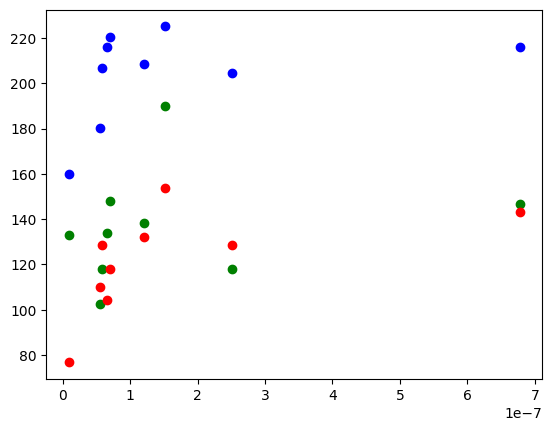

In [70]:
PATH = "./thickness model optical/line profile data/Chip2"

def RGB(filename):
    
    df_A10 = pd.read_excel(PATH+"/"+filename)
    # print(df_A10)
    A10_B = np.average(df_A10["Blue(1)"].to_numpy())
    A10_R = np.average(df_A10["Red(1)"].to_numpy())
    A10_G = np.average(df_A10["Green(1)"].to_numpy())
    return np.array([A10_B,A10_G,A10_R])

A10 = RGB("A10.xlsx")
B15 = RGB("B15.xlsx")
C10_A1 = RGB("C10_A1.xlsx")
C10_A2 = RGB("C10_A2.xlsx")
C15_A1 = RGB("C15_A1.xlsx")
C15_A2 = RGB("C15_A2.xlsx")
D9 = RGB("D9.xlsx")
H12 = RGB("H12.xlsx")
N8 = RGB("N8.xlsx")
N15 = RGB("N15.xlsx")

optical_data = ([[spectraldata10["thickness"]["A10 Area 1"],*A10],
                         [spectraldata10["thickness"]["B15 Area 1"],*B15],
                         [spectraldata10["thickness"]["C10 Area 1"],*C10_A1],
                         [spectraldata10["thickness"]["C10 Area 2"],*C10_A2],
                         [spectraldata10["thickness"]["C15 Area 1"],*C15_A1],
                         [spectraldata10["thickness"]["C15 Area 2"],*C15_A2],
                         [spectraldata10["thickness"]["D9 Area 1"],*D9],
                         [spectraldata10["thickness"]["H12 Area 1"],*H12],
                         [spectraldata10["thickness"]["N15 Area 1"],*N15]])
# print(optical_data)
optical_data = np.array(optical_data)
print(optical_data[optical_data[:, 0].argsort()[::-1]])

plt.scatter(optical_data[:,0],optical_data[:,1],color="b")
plt.scatter(optical_data[:,0],optical_data[:,2],color="g")
plt.scatter(optical_data[:,0],optical_data[:,3],color="r")
# plt.plot(optical_data[:,0],optical_data[:,1],color="b")
# plt.plot(optical_data[:,0],optical_data[:,2],color="g")
# plt.plot(optical_data[:,0],optical_data[:,3],color="r")
plt.show

In [244]:
curr = (np.array([114,190,53])-19.6)/31192.46
print((np.polyfit(curr,[100,200,50],1)))
print(3.44302254e+04)

[3.44302254e+04 6.94898465e+00]
34430.2254
